In [14]:
import torchvision
import torch
from torchinfo import summary
from torchvision.models.detection.ssdlite import SSDLite320_MobileNet_V3_Large_Weights

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2

# load a model, where the backbone is already trained, and the output layers aren't (at least, this should be the case...)
# also set the number of output classes to the number we need
model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=None, num_classes=num_classes, weights_backbone=True)

# load a model with fully pretrained weights
trained_model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1)

# doesn't seem to work
#model.head.classification_head = new_model.head.classification_head


# freeze all layers, except the output heads
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True 

In [15]:
# print a model summary, to see the structure
# in the model with untrained heads, the number of parameters in the regression head is the same, 
# but the classification head drops from 1,286,604  (for 91 classes) to 64,104 (for 2 classes)

summary(model=model,   # can also look at "model=trained_model"
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
SSD (SSD)                                                              [32, 3, 224, 224]    [138, 4]             --                   Partial
├─GeneralizedRCNNTransform (transform)                                 [32, 3, 224, 224]    [32, 3, 320, 320]    --                   --
├─SSDLiteFeatureExtractorMobileNet (backbone)                          [32, 3, 320, 320]    [32, 128, 1, 1]      --                   False
│    └─Sequential (features)                                           --                   --                   --                   False
│    │    └─Sequential (0)                                             [32, 3, 320, 320]    [32, 672, 20, 20]    (869,096)            False
│    │    └─Sequential (1)                                             [32, 672, 20, 20]    [32, 960, 10, 10]    (2,102,856)          False
│    └─ModuleList

## See if the model actually functions

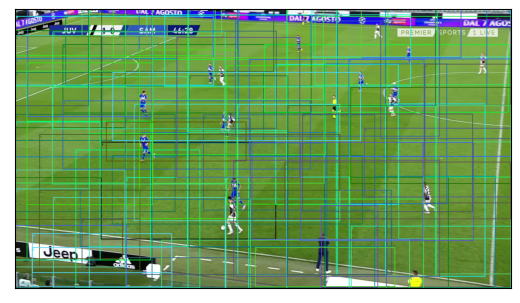

In [16]:
from torchvision.utils import draw_bounding_boxes, save_image
from torchvision.io import read_image
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from PIL import Image
from torchvision import transforms

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# load the image
convert_tensor = transforms.ToTensor()

image_path = "sample_75.jpg"
img = Image.open(image_path)

inputs = [convert_tensor(img)]

# prepare the model 
device = torch.device('cpu') # force CPU, for now
model.to(device)
model.eval()
output = model(inputs)



boxes = output[0]['boxes']
labels = output[0]['labels'].tolist()
labels = [str(i) for i in labels]

disp_image = read_image(image_path)
result = draw_bounding_boxes(disp_image, boxes, labels=labels, width=3)
show(result)

### see what the fully-pretrained one looks like

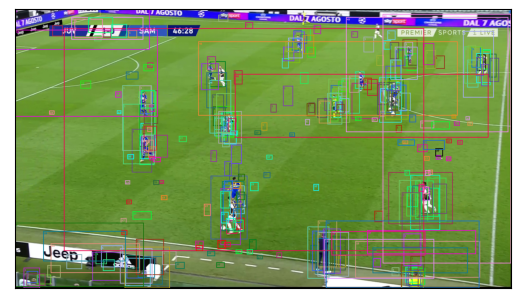

In [17]:
trained_model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1)


# load the image
convert_tensor = transforms.ToTensor()

image_path = "sample_75.jpg"
img = Image.open(image_path)

inputs = [convert_tensor(img)]
    
# prepare the model 
device = torch.device('cpu') # force CPU, for now
trained_model.to(device)
trained_model.eval()
output = trained_model(inputs)

boxes = output[0]['boxes']
labels = output[0]['labels'].tolist()
labels = [str(i) for i in labels]

disp_image = read_image(image_path)
result = draw_bounding_boxes(disp_image, boxes, labels=labels, width=3)
show(result)
